1st

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset folder
dataset_path = '/content/drive/My Drive/dataset_cancer_v1'

# Example: list files in the folder
import os
print(os.listdir(dataset_path))

Mounted at /content/drive
['classificacao_multiclasse', 'classificacao_binaria']


2nd

Total images found: 14330


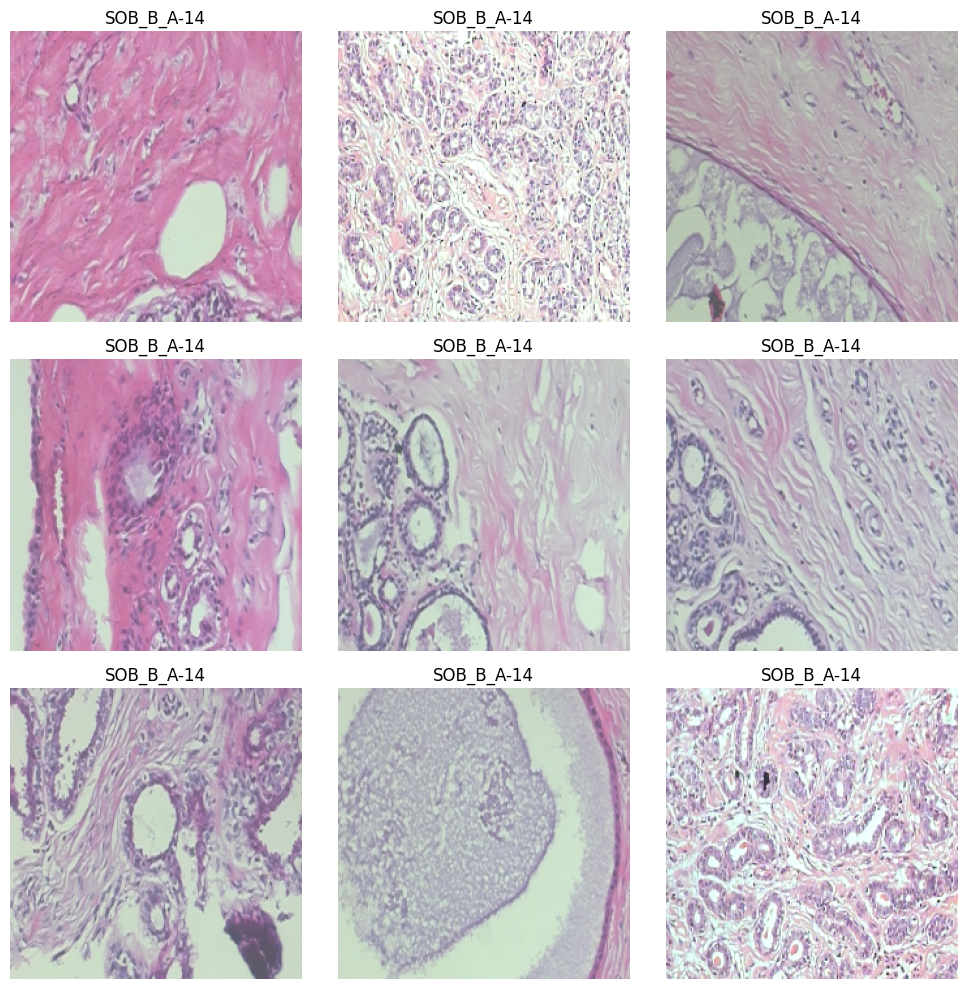

In [2]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to your dataset
dataset_path = '/content/drive/My Drive/dataset_cancer_v1'

# Get all images inside all subfolders (png, jpg, jpeg)
all_images = glob.glob(dataset_path + '/**/*.png', recursive=True) + \
             glob.glob(dataset_path + '/**/*.jpg', recursive=True) + \
             glob.glob(dataset_path + '/**/*.jpeg', recursive=True)

print("Total images found:", len(all_images))

# Display first 9 images in a grid
plt.figure(figsize=(10,10))
for i, img_path in enumerate(all_images[:9]):
    img = mpimg.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path)[:10])  # short filename

plt.tight_layout()
plt.show()

3rd

In [3]:
import random
class_names = sorted(os.listdir(dataset_path))
print("Classes found:", class_names)

# Number of images per class to show
samples_per_class = 5

plt.figure(figsize=(15, 10))

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    images = glob.glob(class_path + "/*.jpg") + glob.glob(class_path + "/*.png") + glob.glob(class_path + "/*.jpeg")

    # pick random samples from this class
    sample_imgs = random.sample(images, min(samples_per_class, len(images)))

    for j, img_path in enumerate(sample_imgs):
        plt.subplot(len(class_names), samples_per_class, idx * samples_per_class + j + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis("off")
        if j == 0:   # label only once per row
            plt.ylabel(class_name, fontsize=12, rotation=90)

plt.tight_layout()
plt.show()

Classes found: ['classificacao_binaria', 'classificacao_multiclasse']


<Figure size 1500x1000 with 0 Axes>

4th

In [4]:
import os

dataset_path = '/content/drive/My Drive/dataset_cancer_v1' # Ensure dataset_path points to the root directory
binary_path = os.path.join(dataset_path, "classificacao_binaria")
multiclass_path = os.path.join(dataset_path, "classificacao_multiclasse")

print("Binary subfolders:", os.listdir(binary_path))
print("Multiclass subfolders:", os.listdir(multiclass_path))

Binary subfolders: ['100X', '400X', '40X', '200X']
Multiclass subfolders: ['100X', '400X', '40X', '200X']


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def get_generators(base_path, magnification, mode="binary", img_size=(224,224), batch_size=32):
    """
    base_path: path to dataset (binary or multiclass folder)
    magnification: "40X", "100X", etc.
    mode: "binary" or "categorical"
    """
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    print(f"Loading data from {os.path.join(base_path, magnification)} in {mode} mode...")

    train_gen = datagen.flow_from_directory(
        os.path.join(base_path, magnification),
        target_size=img_size,
        batch_size=batch_size,
        class_mode=mode,
        subset="training"
    )

    val_gen = datagen.flow_from_directory(
        os.path.join(base_path, magnification),
        target_size=img_size,
        batch_size=batch_size,
        class_mode=mode,
        subset="validation"
    )

    return train_gen, val_gen

5th

In [6]:
dataset_path = '/content/drive/My Drive/dataset_cancer_v1'
binary_path = os.path.join(dataset_path, "classificacao_binaria")
multiclass_path = os.path.join(dataset_path, "classificacao_multiclasse")

# Example: Binary classification, 40X
train_gen, val_gen = get_generators(binary_path, "40X", mode="binary")

Loading data from /content/drive/My Drive/dataset_cancer_v1/classificacao_binaria/40X in binary mode...
Found 1284 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


6th

In [7]:
# Path to multiclass dataset
multiclass_path = os.path.join(dataset_path, "classificacao_multiclasse")

# Example: 40X magnification
train_gen_multi, val_gen_multi = get_generators(multiclass_path, "40X", mode="categorical")

Loading data from /content/drive/My Drive/dataset_cancer_v1/classificacao_multiclasse/40X in categorical mode...
Found 1709 images belonging to 8 classes.
Found 423 images belonging to 8 classes.


CNN

7th

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_path = '/content/drive/MyDrive/dataset_cancer_v1/classificacao_binaria'
image_size = (224, 224)
batch_size = 32

# Create a dataset that reads images on the fly (instead of all at once)
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Improve performance by prefetching batches
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 6278 files belonging to 4 classes.
Using 5023 files for training.
Found 6278 files belonging to 4 classes.
Using 1255 files for validation.


8th

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

dataset_path = '/content/drive/MyDrive/dataset_cancer_v1/classificacao_multiclasse'
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224,224),
    batch_size=32,
    label_mode='int'  # important
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224,224),
    batch_size=32,
    label_mode='int'
)

# Normalize pixel values to [0,1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Apply augmentation only to training set
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 8052 files belonging to 4 classes.
Using 6442 files for training.
Found 8052 files belonging to 4 classes.
Using 1610 files for validation.


9th

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load pre-trained VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze pre-trained layers
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
202/202 ━━━━━━━━━━━━━━━━━━━━ 5406s 27s/step - accuracy: 0.2456 - loss: -31.2241 - val_accuracy: 0.2615 - val_loss: -226.3630


In [11]:
# Evaluate model on validation/test dataset
loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)
print("Validation Loss:", loss)

# Save model to Google Drive
model.save('/content/drive/MyDrive/vgg16_binary_model.h5')
print("Model saved successfully!")


51/51 ━━━━━━━━━━━━━━━━━━━━ 1041s 20s/step - accuracy: 0.2668 - loss: -214.7971


Validation Accuracy: 0.26149067282676697
Validation Loss: -226.3629608154297
Model saved successfully!


In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

num_classes = 8   # <-- change to your number of classes

# Load VGG16
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')   # MULTI-CLASS
])

# Compile
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',   # MULTI-CLASS LOSS
    metrics=['accuracy']
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)


202/202 ━━━━━━━━━━━━━━━━━━━━ 5211s 26s/step - accuracy: 0.4650 - loss: 1.2288 - val_accuracy: 0.7677 - val_loss: 0.6273


In [13]:
loss, accuracy = model.evaluate(val_ds)
print("Validation Accuracy:", accuracy)

# Save model
model.save('/content/drive/MyDrive/vgg16_multiclass_model.h5')
print("Multiclass model saved!")


51/51 ━━━━━━━━━━━━━━━━━━━━ 1013s 20s/step - accuracy: 0.7662 - loss: 0.6196


Validation Accuracy: 0.7677018642425537
Multiclass model saved!
